In [5]:
import numpy as np


# To read the training data and make a vocabulary and dictiornary to index the chars
class DataReader:
    def __init__(self, path, seq_length):
        #uncomment below , if you dont want to use any file for text reading and comment next 2 lines
        #self.data = "some really long text to test this. maybe not perfect but should get you going."
        self.fp = open(path, "r")
        self.data = self.fp.read()
        #find unique chars
        chars = list(set(self.data))
        #create dictionary mapping for each char
        self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
        self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
        #total data
        self.data_size = len(self.data)
        #num of unique chars
        self.vocab_size = len(chars)
        self.pointer = 0
        self.seq_length = seq_length

    def next_batch(self):
        input_start = self.pointer
        input_end = self.pointer + self.seq_length
        inputs = [self.char_to_ix[ch] for ch in self.data[input_start:input_end]]
        targets = [self.char_to_ix[ch] for ch in self.data[input_start+1:input_end+1]]
        self.pointer += self.seq_length
        if self.pointer + self.seq_length + 1 >= self.data_size:
            # reset pointer
            self.pointer = 0
        return inputs, targets

    def just_started(self):
        return self.pointer == 0

    def close(self):
        self.fp.close()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    p = np.exp(x - np.max(x))
    return p / np.sum(p)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def dtanh(y):
    return 1 - np.square(y)

In [18]:
class LSTM:
    def __init__(self, hidden_size, vocab_size, seq_length, learning_rate):
        # Hyperparameters
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        # LSTM parameters
        # Weights
        self.Wf = np.random.randn(hidden_size, hidden_size + vocab_size) # forget gate
        self.Wi = np.random.randn(hidden_size, hidden_size + vocab_size) # input gate
        self.Wo = np.random.randn(hidden_size, hidden_size + vocab_size) # output gate
        self.Wc = np.random.randn(hidden_size, hidden_size + vocab_size) # candidate cell state
        # Biases
        self.bf = np.zeros((hidden_size, 1)) # forget gate
        self.bi = np.zeros((hidden_size, 1)) # input gate
        self.bo = np.zeros((hidden_size, 1)) # output gate
        self.bc = np.zeros((hidden_size, 1)) # candidate cell state

        # Output layer parameters
        self.Wy = np.random.randn(vocab_size, hidden_size)
        self.by = np.zeros((vocab_size, 1))

        # Memory variables for Adagrad
        self.mWf, self.mWi, self.mWo, self.mWc = [np.zeros_like(mat) for mat in [self.Wf, self.Wi, self.Wo, self.Wc]]
        self.mWy = np.zeros_like(self.Wy)
        self.mbf, self.mbi, self.mbo, self.mbc = [np.zeros_like(vec) for vec in [self.bf, self.bi, self.bo, self.bc]]
        self.mby = np.zeros_like(self.by)

    def forward(self, inputs, hprev, cprev):
        # Initialize all the variables for the forward pass
        # x = input, h = hidden state, c = cell state, 
        # y = output, p = probabilities
        # i = input gate, f = forget gate, o = output gate
        x, h, c, y, p, i, f, o = {}, {}, {}, {}, {}, {}, {}, {}
        
        # At timestep 0 we don't have a previous hidden state, so we initialize it with zeros
        h[-1], c[-1] = np.copy(hprev), np.copy(cprev)
        
        for t in range(len(inputs)):
            
            # One-hot encoding for input character
            x[t] = np.zeros((self.vocab_size, 1))
            x[t][inputs[t]] = 1  # e.g. if inputs[t] = 3 then x[t] = [0, 0, 0, 1, 0, 0, 0, 0, 0]
            
            # Concatenation: [h(t-1), x(t)]
            z = np.row_stack((h[t-1], x[t]))
            
            # LSTM cell operations
            # Forget gate 
            f[t] = sigmoid(np.dot(self.Wf, z) + self.bf)
            # Input gate
            i[t] = sigmoid(np.dot(self.Wi, z) + self.bi)
            # Candidate cell state
            c_bar = np.tanh(np.dot(self.Wc, z) + self.bc)
            # Output gate
            o[t] = sigmoid(np.dot(self.Wo, z) + self.bo)
            # Cell state update
            c[t] = f[t]*c[t-1] + i[t]*c_bar
            # Hidden state
            h[t] = o[t] * np.tanh(c[t])

            # Output layer - softmax
            y[t] = np.dot(self.Wy, h[t]) + self.by
            p[t] = softmax(y[t])

        # Return all values computed for the forward pass
        return x, h, c, p, y, i, f, o
    
    def backward(self, targets, x, h, c, p, y, i, f, o):
        # Initialize all gradients
        dWf, dWi, dWo, dWc = np.zeros_like(self.Wf), np.zeros_like(self.Wi), np.zeros_like(self.Wo), np.zeros_like(self.Wc)
        dbf, dbi, dbo, dbc = np.zeros_like(self.bf), np.zeros_like(self.bi), np.zeros_like(self.bo), np.zeros_like(self.bc)
        dWy, dby = np.zeros_like(self.Wy), np.zeros_like(self.by)
        
        # Initialize vectors for gradient values for each gate
        dhnext = np.zeros_like(h[0])
        dcnext = np.zeros_like(c[0])

        # Backpropagation through time - BPTT (for all time steps)
        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] -= 1  # backprop into y

            dWy += np.dot(dy, h[t].T)
            dby += dy

            dh = np.dot(self.Wy.T, dy) + dhnext
            do = dh * np.tanh(c[t])
            do = dsigmoid(o[t]) * do
            dWo += np.dot(do, np.row_stack((h[t-1], x[t])).T)
            dbo += do

            dc = dh * o[t] * dtanh(np.tanh(c[t])) + dcnext
            dcprev = dc * f[t]
            df = dc * c[t-1]
            df = dsigmoid(f[t]) * df
            dWf += np.dot(df, np.row_stack((h[t-1], x[t])).T)
            dbf += df
            
            di = dc * np.tanh(np.dot(self.Wc, np.row_stack((h[t-1], x[t]))) + self.bc)
            di = dsigmoid(i[t]) * di
            dWi += np.dot(di, np.row_stack((h[t-1], x[t])).T)
            dbi += di
            
            dcbar = dc * i[t]
            dcbar = dtanh(np.tanh(np.dot(self.Wc, np.row_stack((h[t-1], x[t]))) + self.bc)) * dcbar
            dWc += np.dot(dcbar, np.row_stack((h[t-1], x[t])).T)
            dbc += dcbar
            
            dz = (np.dot(self.Wf.T, df) + np.dot(self.Wi.T, di) + np.dot(self.Wo.T, do) + np.dot(self.Wc.T, dcbar))
            dhnext = dz[:self.hidden_size, :]
            dcnext = dcprev
            
        # Clipping gradients to mitigate exploding gradients
        for dparam in [dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWy, dby]:
            np.clip(dparam, -5, 5, out=dparam)

        return dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWy, dby


    def update_model(self, dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWy, dby):
        # Update Adagrad memory
        for param, dparam, mem in zip([self.Wf, self.Wi, self.Wo, self.Wc, self.bf, self.bi, self.bo, self.bc, self.Wy, self.by],
                                      [dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWy, dby],
                                      [self.mWf, self.mWi, self.mWo, self.mWc, self.mbf, self.mbi, self.mbo, self.mbc, self.mWy, self.mby]):
            mem += dparam * dparam
            param -= self.learning_rate * dparam / np.sqrt(mem + 1e-8)
            
    
    def train(self, data_reader, patience=10, min_delta=0.001):
        
        loss_history = []
        smoothloss_history = []
        iter_num = 0
        threshold = 0.01
        smooth_loss = -np.log(1.0 / self.vocab_size) * self.seq_length
        smoothloss_history.append(smooth_loss)

        best_loss = float('inf')
        iter_since_last_improvement = 0

        while smooth_loss > threshold and iter_since_last_improvement < patience:
            
            if data_reader.just_started():
                hprev = np.zeros((self.hidden_size, 1))
                cprev = np.zeros((self.hidden_size, 1))

            inputs, targets = data_reader.next_batch()

            # Forward pass
            x, h, c, p, y, i, f, o = self.forward(inputs, hprev, cprev)

            # Compute loss
            loss = -np.sum(np.log(np.array([p[t][targets[t], 0] for t in range(self.seq_length)]))) / self.seq_length
            loss_history.append(loss)
            
            # Backward pass
            dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWy, dby = self.backward(targets, x, h, c, p, y, i, f, o)

            # Update model parameters
            self.update_model(dWf, dWi, dWo, dWc, dbf, dbi, dbo, dbc, dWy, dby)

            smooth_loss = smooth_loss * 0.999 + loss * 0.001
            smoothloss_history.append(smooth_loss)
            hprev, cprev = h[self.seq_length - 1], c[self.seq_length - 1]

            # Early stopping check
            if loss < best_loss - min_delta:
                best_loss = loss
                iter_since_last_improvement = 0
            else:
                iter_since_last_improvement += 1

            iter_num += 1
            if iter_num % 100 == 0:
                print(f'Iter: {iter_num}, Loss: {smooth_loss:.4f}')

        print("Training stopped. Best loss:", best_loss)

        # Plot the losses over time
        plt.plot(loss_history, 'b', label='loss')
        plt.plot(smoothloss_history, 'r', label='smooth loss')
        plt.xlabel('Time')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, seed_idx, n):
        """
        Sample a sequence of integers from the model.
        seed_idx is seed letter for first time step.
        """
        # Reset memory (hidden state and cell state)
        h = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))
        # One-hot encode seed char
        x = np.zeros((self.vocab_size, 1))
        x[seed_idx] = 1
        ixes = []

        # Forward pass, for n time steps
        for t in range(n):
            # Forward step = one forward pass through the LSTM cell
            h, c = self.forward_step(x, h, c)
            y = np.dot(self.Wy, h) + self.by
            p = softmax(y)
            # Sample index from the probability distribution
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            # One-hot encode the sample to be the input for the next time step
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            ixes.append(ix)
            
        txt = ''.join(data_reader.ix_to_char[ix] for ix in ixes)
        print(f"----\n {txt} \n----\n")
        return ixes

    def forward_step(self, x, h, c):
        """
        Forward step for a single time step.
        """
        # Concatenation: [h(t-1), x(t)]
        z = np.row_stack((h, x))
        # Forget gate
        f = sigmoid(np.dot(self.Wf, z) + self.bf)
        # Input gate
        i = sigmoid(np.dot(self.Wi, z) + self.bi)
        # Output gate
        o = sigmoid(np.dot(self.Wo, z) + self.bo)
        # Candidate cell state
        c_bar = np.tanh(np.dot(self.Wc, z) + self.bc)
        # Cell state
        c = f * c + i * c_bar
        # Hidden state
        h = o * np.tanh(c)
        return h, c


Iter: 100, Loss: 90.0733
Iter: 200, Loss: 82.0890
Iter: 300, Loss: 74.8049
Iter: 400, Loss: 68.1791
Iter: 500, Loss: 62.1536
Iter: 600, Loss: 56.6780
Iter: 700, Loss: 51.7124
Iter: 800, Loss: 47.1867
Iter: 900, Loss: 43.0782
Iter: 1000, Loss: 39.3526
Iter: 1100, Loss: 35.9696
Iter: 1200, Loss: 32.9081
Iter: 1300, Loss: 30.1297
Iter: 1400, Loss: 27.6024
Iter: 1500, Loss: 25.3127
Iter: 1600, Loss: 23.2366
Iter: 1700, Loss: 21.3606
Iter: 1800, Loss: 19.6626
Iter: 1900, Loss: 18.1212
Iter: 2000, Loss: 16.7220
Iter: 2100, Loss: 15.4542
Iter: 2200, Loss: 14.3082
Iter: 2300, Loss: 13.2669
Iter: 2400, Loss: 12.3214
Iter: 2500, Loss: 11.4674
Iter: 2600, Loss: 10.6899
Iter: 2700, Loss: 9.9845
Iter: 2800, Loss: 9.3472
Iter: 2900, Loss: 8.7681
Iter: 3000, Loss: 8.2401
Iter: 3100, Loss: 7.7654
Iter: 3200, Loss: 7.3308
Iter: 3300, Loss: 6.9422
Iter: 3400, Loss: 6.5854
Iter: 3500, Loss: 6.2624
Iter: 3600, Loss: 5.9682
Iter: 3700, Loss: 5.7019
Iter: 3800, Loss: 5.4565
Iter: 3900, Loss: 5.2358
Iter: 40

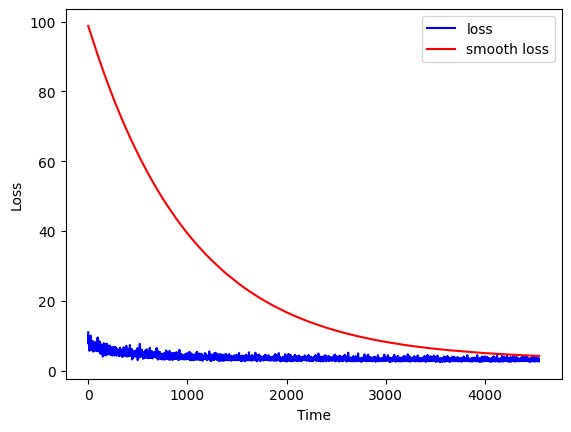

In [20]:
seq_length = 25
# Assuming you have a DataReader class similar to the one used with RNN
data_reader = DataReader("input.txt", seq_length)

# Create an instance of the LSTM class
lstm = LSTM(hidden_size=100, vocab_size=data_reader.vocab_size, seq_length=seq_length, learning_rate=1e-1)

# Train the LSTM
lstm.train(data_reader, patience=1000, min_delta=0.001)

In [ ]:

# Sample from the trained LSTM model
# Start with a seed index (e.g., the index of a character)
seed_index = data_reader.char_to_ix['a']  # example starting with character 'a'

# Generate a sequence of 200 characters
sampled_text = lstm.predict(seed_index, 200)

# Convert indices back to characters
generated_text = ''.join(data_reader.ix_to_char[ix] for ix in sampled_text)
print(generated_text)

# Use sentence prefix to generate text
prefix = "Neural "
seed_index = data_reader.char_to_ix[prefix[-1]]
sampled_text = lstm.predict(seed_index, 200)
generated_text = ''.join(data_reader.ix_to_char[ix] for ix in sampled_text)
print(generated_text) 